In [34]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import os

from packages import timeconvert as tc

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import MultipleLocator,FixedLocator,FormatStrFormatter

date = '7_25_2021'

timeRange = ["00","07"]

refants = np.array(['DA59','DV11','DA49','DV12','PM01','DV07'])

#'''

In [35]:
directory = '/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/'

def colorbar(mappable,norm,vmin,vmax):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, boundaries=[vmin,0.8*vmin,0.6*vmin,0.4*vmin,0.2*vmin,0,0.2*vmax,0.4*vmax,0.6*vmax,0.8*vmax,vmax],ticks=[vmin,0.5*vmin,0,0.5*vmax,vmax])
    cbar.set_label('(m)')
    plt.sca(last_axes)
    return cbar

uids = []
for file in os.listdir(directory): ##for subdirectory in 7_12_2021
    if os.path.isdir(directory+file) and file[:3] == 'uid':
        asdmXML = open(directory+file+'/ASDM.xml',"r")
        for i in range(4): line = asdmXML.readline()
        time = re.sub(r"<.*?>", "", line).strip()
        time = tc.UnixtoFormattedTime(tc.FormattedTimetoUnix(time))
        if float(timeRange[0]) <= float(time[7:9]) and float(time[7:9]) <= float(timeRange[1]):
            uids.append(file)

# surface plot (magnitude)

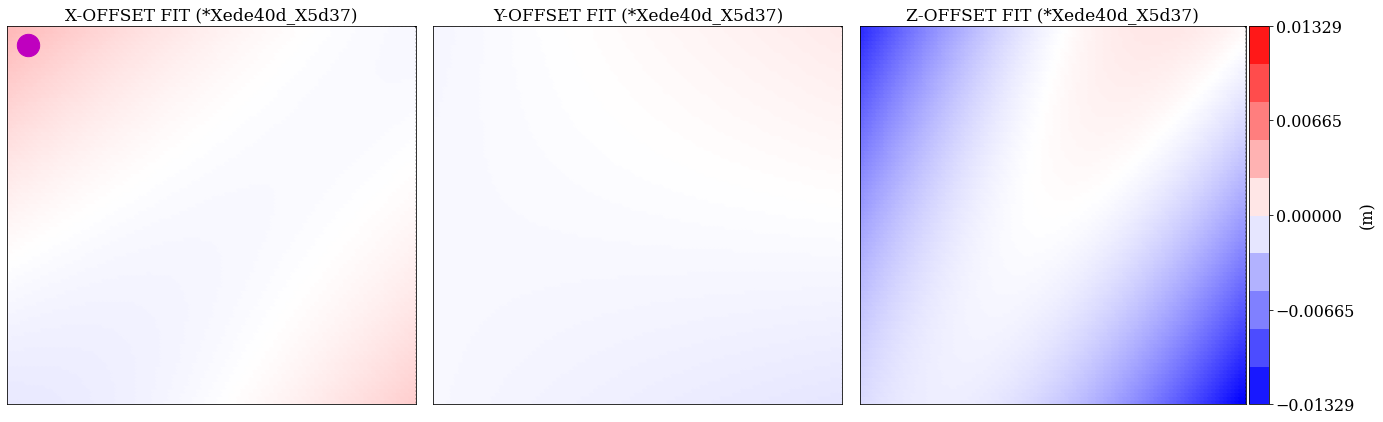

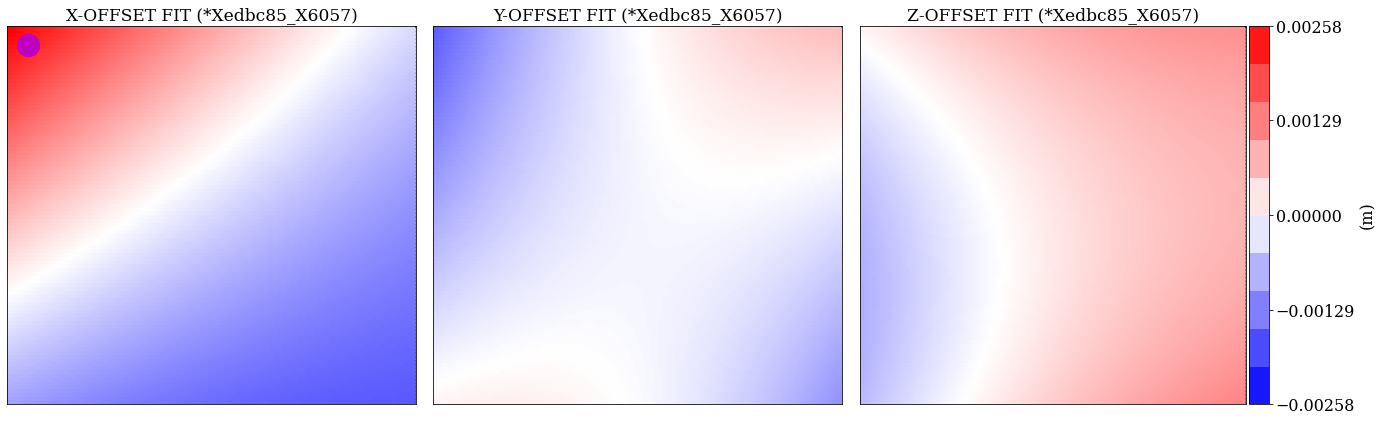

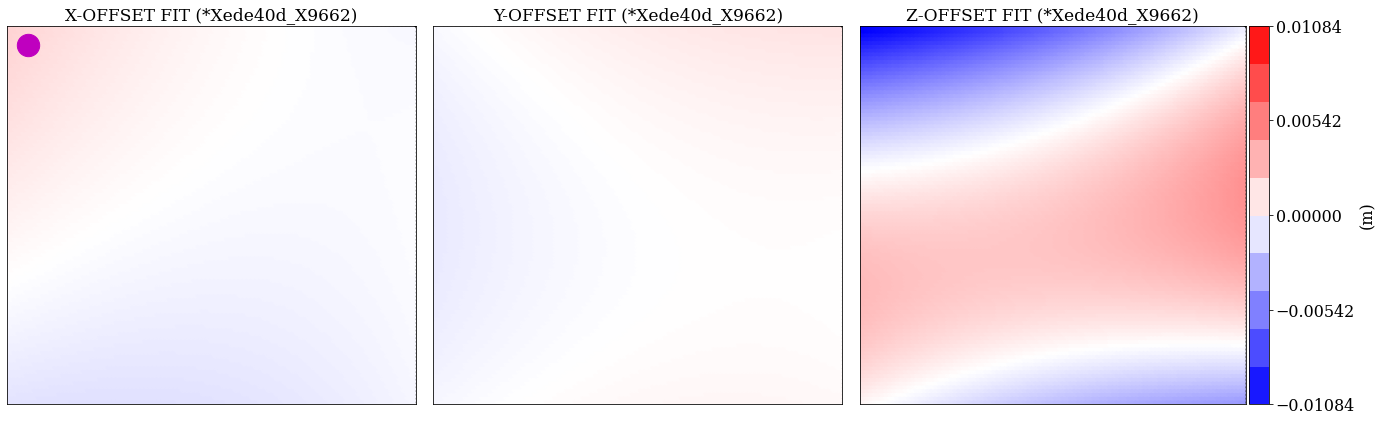

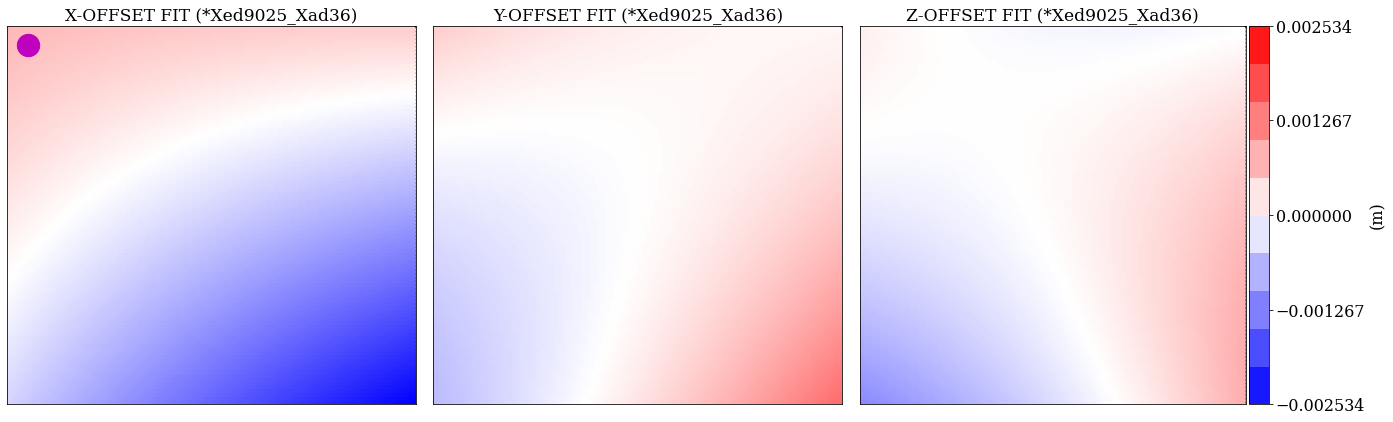

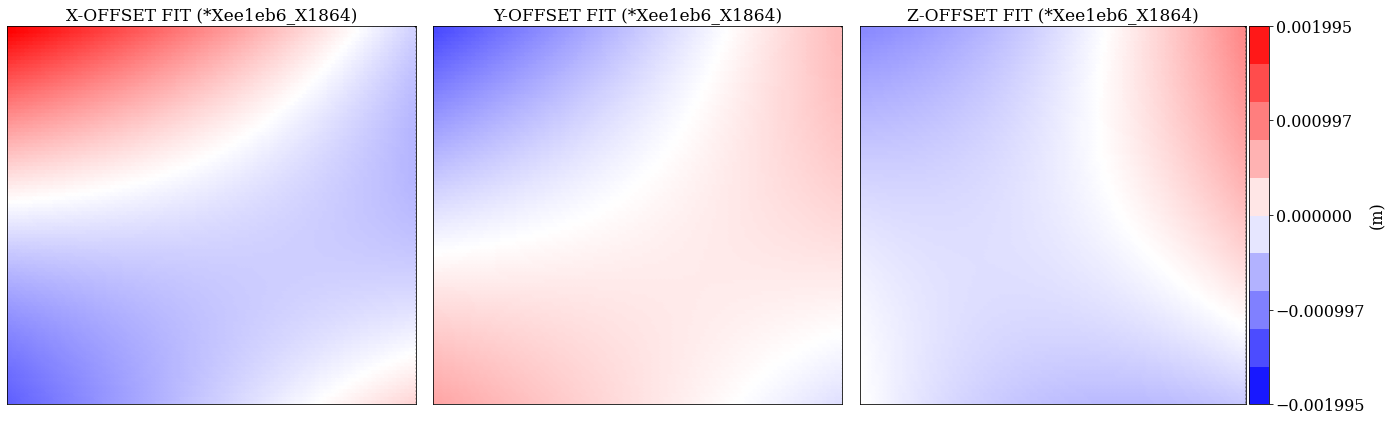

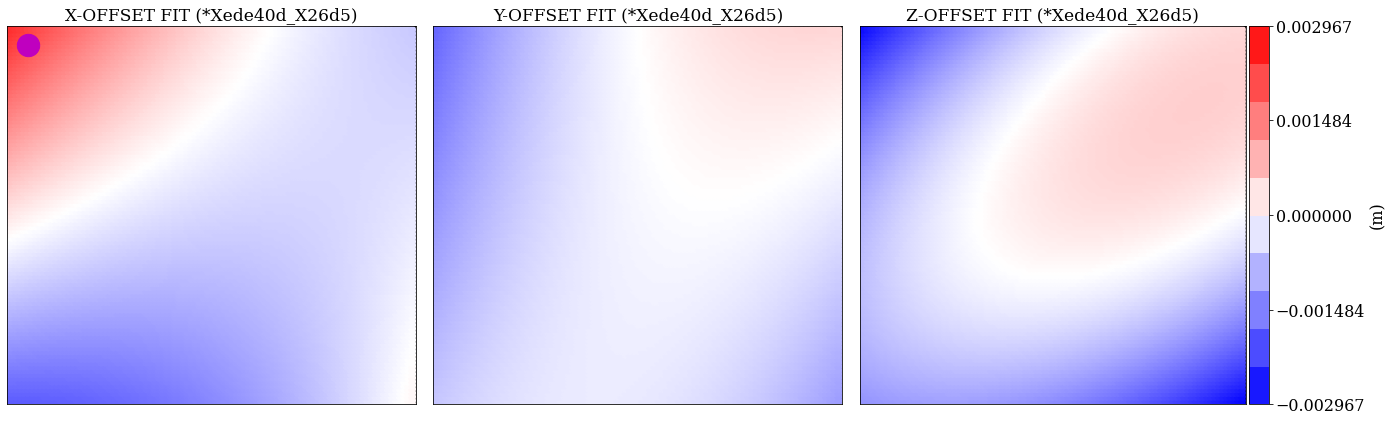

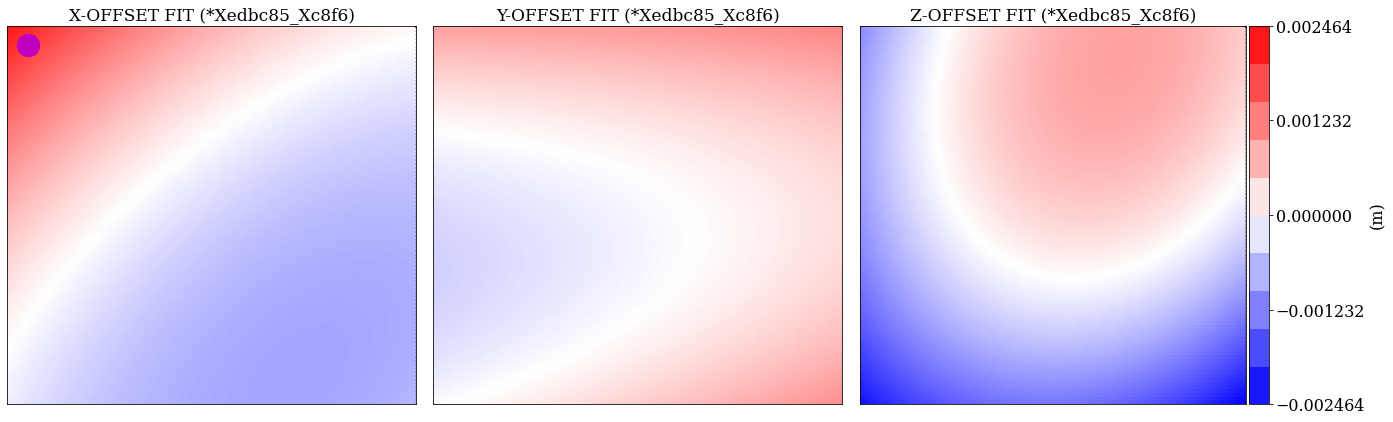

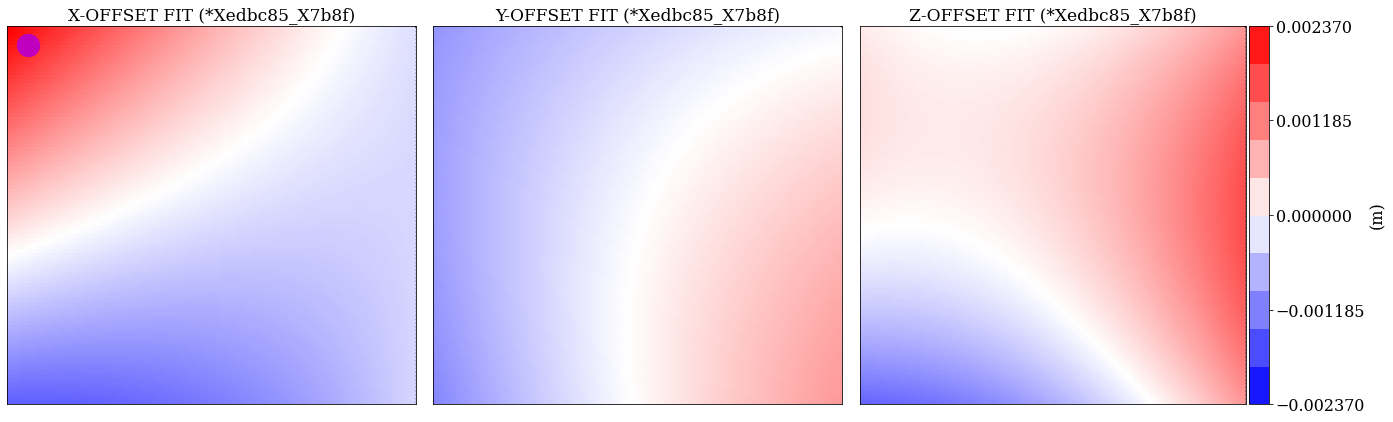

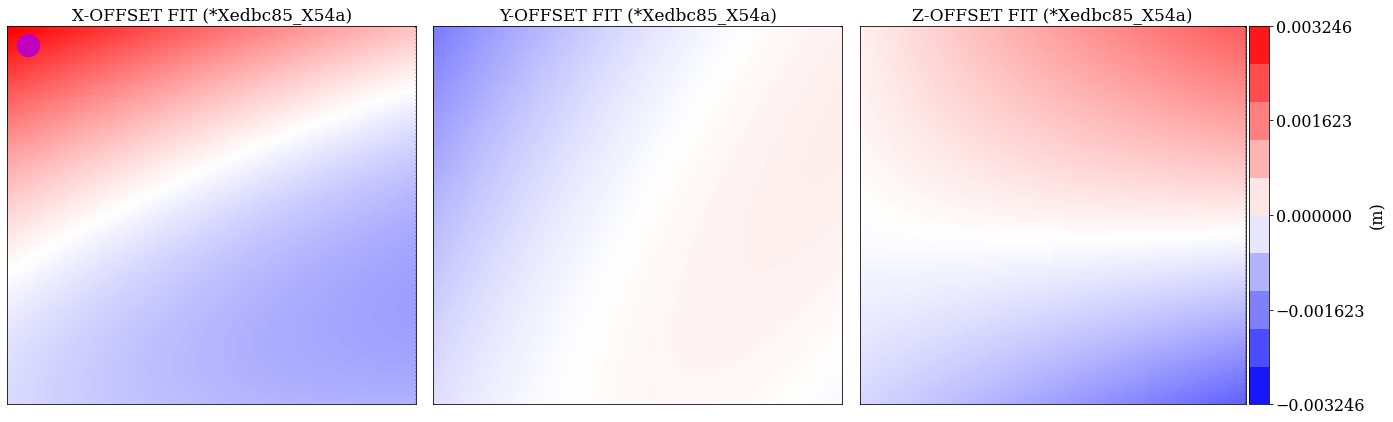

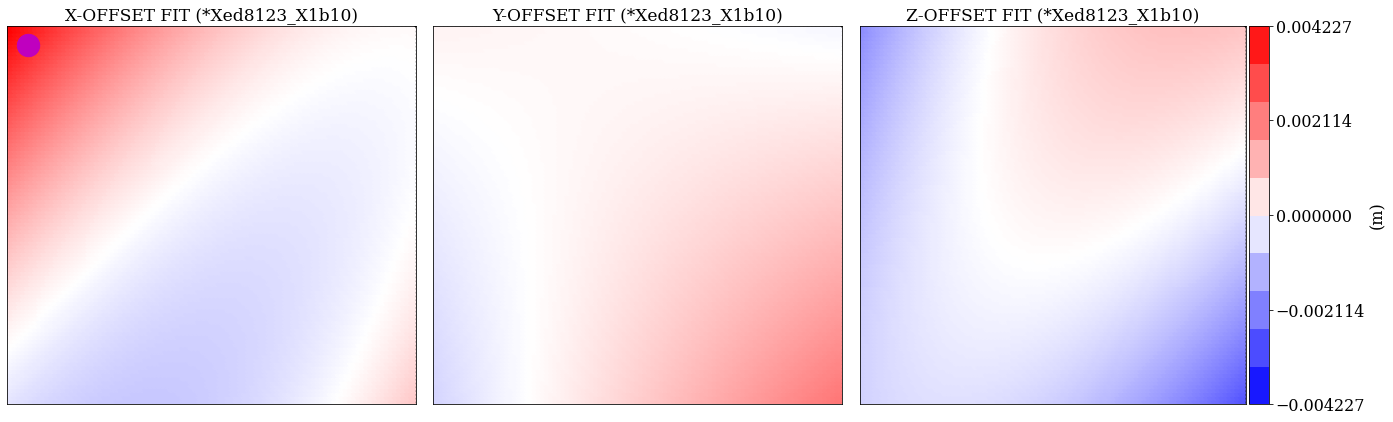

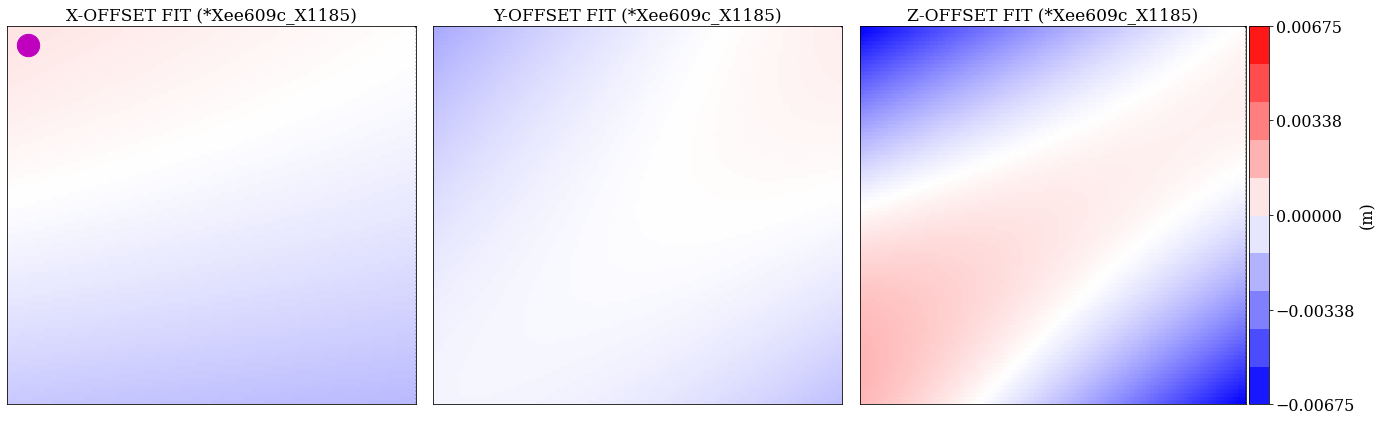

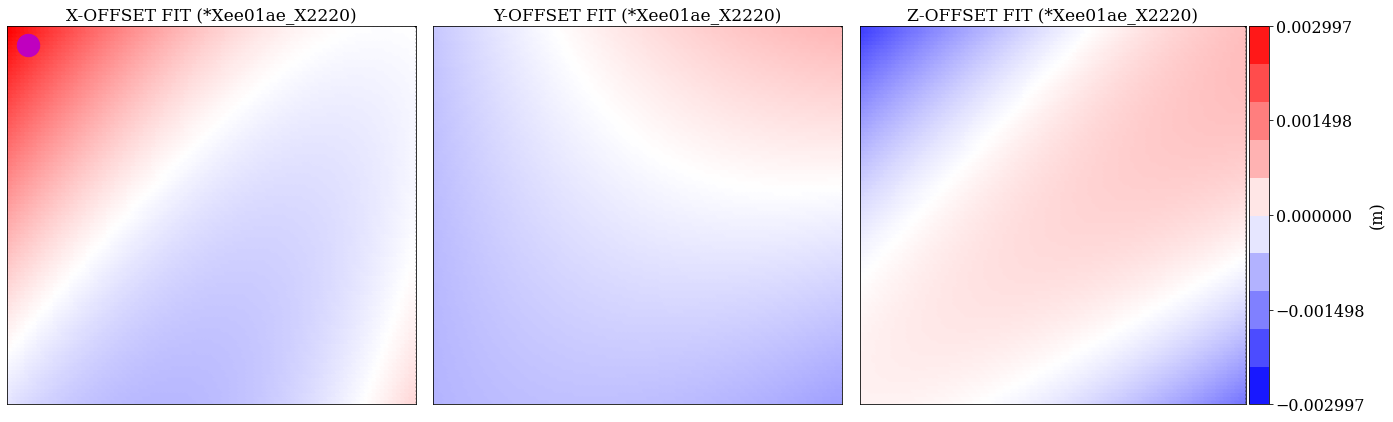

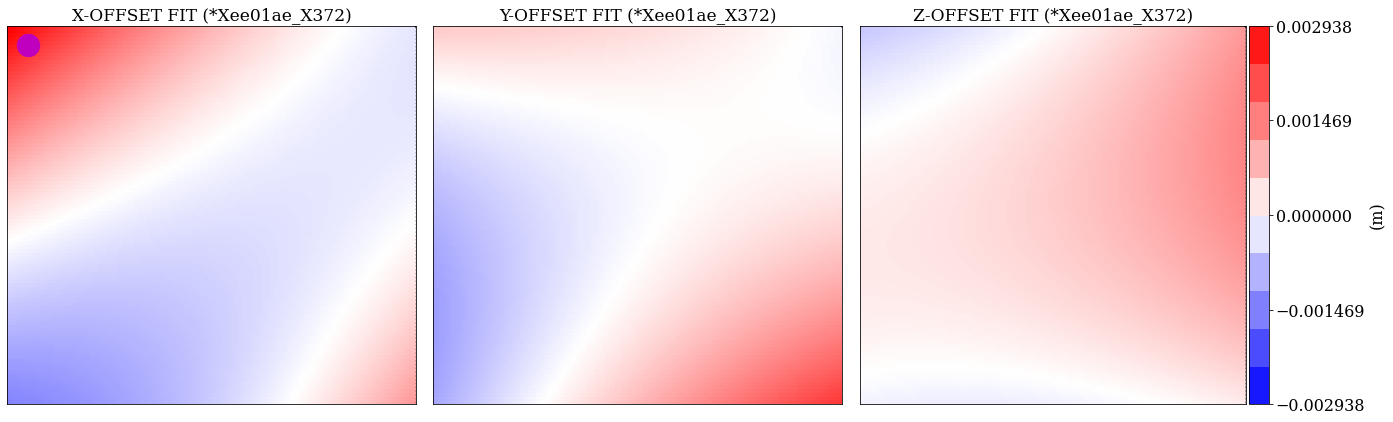

In [36]:
if not os.path.isdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/'):
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/magnitude/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/delta/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/magnitude/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/delta/')
directory = '/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/'

o = 0

for file in os.listdir(directory): ##for subdirectory in 7_12_2021
    if os.path.isdir(directory+file) and file[:3] == 'uid':
        if file in uids:

            ############################################ Fits

            temp = np.genfromtxt(directory+file+'/AntPos.csv',delimiter=',',dtype='str',skip_header=2)
            X = temp[:,15].astype('float')
            Y = temp[:,16].astype('float')

            ###############

            XOffset = temp[:,3].astype('float')
            YOffset = temp[:,4].astype('float')
            ZOffset = temp[:,5].astype('float')

            k = np.sort(XOffset)
            dev = (k[-4]-k[4])/2
            xmax = k[-4]+dev
            xmin = k[4]-dev

            k = np.sort(YOffset)
            dev = (k[-4]-k[4])/2
            ymax = k[-4]+dev
            ymin = k[4]-dev

            k = np.sort(ZOffset)
            dev = (k[-4]-k[4])/2
            zmax = k[-4]+dev
            zmin = k[4]-dev

            for j in range(np.shape(X)[0]):
                if XOffset[j] > xmax:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if YOffset[j] > ymax:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if ZOffset[j] > zmax:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if XOffset[j] < xmin:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if YOffset[j] < ymin:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if ZOffset[j] < zmin:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0


            ###############

            xmax = np.max(X)+200
            ymax = np.max(Y)+200
            xmin = np.min(X)-200
            ymin = np.min(Y)-200

            poly = PolynomialFeatures(degree=2)
            X_t = poly.fit_transform(np.transpose(np.vstack((X,Y))))

            xFit = LinearRegression()
            xFit.fit(X_t, XOffset)
            xCoeff = xFit.coef_
            xInt = xFit.intercept_

            yFit = LinearRegression()
            yFit.fit(X_t, YOffset)
            yCoeff = yFit.coef_
            yInt = yFit.intercept_

            zFit = LinearRegression()
            zFit.fit(X_t, ZOffset)
            zCoeff = zFit.coef_
            zInt = zFit.intercept_

            ############################################

            x = np.arange(xmin, xmax, (xmax-xmin)/100)
            y = np.arange(ymin, ymax, (ymax-ymin)/100)
            if np.shape(x)[0] < np.shape(y)[0]: y = y[:np.shape(x)[0]]
            else: x = x[:np.shape(y)[0]]

            x, y = np.meshgrid(x,y)
            xOffset = xCoeff[1]*x+xCoeff[2]*y+xCoeff[3]*x**2+xCoeff[4]*x*y+xCoeff[5]*y**2+xInt
            yOffset = yCoeff[1]*x+yCoeff[2]*y+yCoeff[3]*x**2+yCoeff[4]*x*y+yCoeff[5]*y**2+yInt
            zOffset = zCoeff[1]*x+zCoeff[2]*y+zCoeff[3]*x**2+zCoeff[4]*x*y+zCoeff[5]*y**2+zInt

            temp = max(np.max(xOffset),np.max(yOffset),np.max(zOffset),-np.min(xOffset),-np.min(yOffset),-np.min(zOffset))
            vmin = -temp
            vmax = temp
            if vmax > 0.002:
                circle = True
            else: circle = False
            norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)

            #graph parameters
            width,height = 18,6
            xMajors,xMinors = 5,5
            yMajors,yMinors = 5,5

            #X PLOT

            fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(width,height))

            title='X-OFFSET FIT (*'+file[11:]+')'

            ax1.scatter(x,y,norm=norm,c=xOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)
            if circle: ax1.scatter(xmin+0.05*(xmax-xmin),ymax-0.05*(ymax-ymin),s=500,c='m',edgecolors='m',linestyle='-',linewidth=1)
            
            plt.rc("font", size=16,family='serif')
            ax1.set_xlim(xmin,xmax)
            ax1.set_ylim(ymin,ymax)
            x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
            y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
            ax1.set_xticks([xmin+200,xmax-200])
            ax1.set_yticks([ymin+200,ymax-200])
            ax1.xaxis.set_minor_locator(x_minor_ticks)
            ax1.yaxis.set_minor_locator(y_minor_ticks)
            ax1.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
            ax1.set_xticklabels(['West','East'])
            ax1.set_yticklabels(['South','North'])
            ax1.set_title(title,fontsize=17)
            ax1.set_facecolor('xkcd:black')
            plt.tight_layout()

            #Y PLOT

            title='Y-OFFSET FIT (*'+file[11:]+')'

            ax2.scatter(x,y,norm=norm,c=yOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)

            plt.rc("font", size=16,family='serif')
            ax2.set_xlim(xmin,xmax)
            ax2.set_ylim(ymin,ymax)
            x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
            y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
            ax2.set_xticks([xmin+200,xmax-200])
            ax2.set_yticks([ymin+200,ymax-200])
            ax2.xaxis.set_minor_locator(x_minor_ticks)
            ax2.yaxis.set_minor_locator(y_minor_ticks)
            ax2.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
            ax2.set_xticklabels(['West','East'])
            ax2.set_yticklabels(['South','North'])
            ax2.set_title(title,fontsize=17)
            ax2.set_facecolor('xkcd:black')
            plt.tight_layout()

            #Z PLOT

            title='Z-OFFSET FIT (*'+file[11:]+')'

            temp = ax3.scatter(x,y,norm=norm,c=zOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)

            plt.rc("font", size=16,family='serif')
            ax3.set_xlim(xmin,xmax)
            ax3.set_ylim(ymin,ymax)
            x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
            y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
            ax3.set_xticks([xmin+200,xmax-200])
            ax3.set_yticks([ymin+200,ymax-200])
            ax3.xaxis.set_minor_locator(x_minor_ticks)
            ax3.yaxis.set_minor_locator(y_minor_ticks)
            ax3.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
            ax3.set_xticklabels(['West','East'])
            ax3.set_yticklabels(['South','North'])
            ax3.set_title(title,fontsize=17)
            ax3.set_facecolor('xkcd:black')
            plt.tight_layout()

            colorbar(temp,norm,vmin,vmax)
            plt.show()
            #plt.savefig(directory+'geographyfitplots/plot/magnitude/maggeofit'+str(o)+'.png', bbox_inches='tight')
            #plt.close()

            o += 1
        
#'''

# surface plot (magnitude) w/ antennas

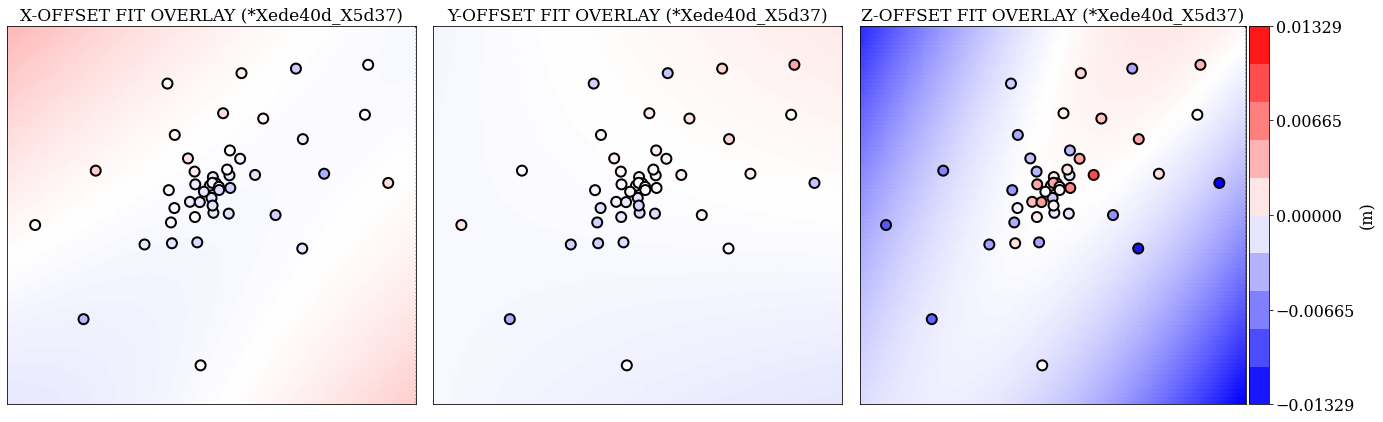

KeyboardInterrupt: 

In [37]:
if not os.path.isdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/'):
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/magnitude/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/delta/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/magnitude/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/delta/')
directory = '/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/'

o = 0

for file in os.listdir(directory): ##for subdirectory in 7_12_2021
    if os.path.isdir(directory+file) and file[:3] == 'uid':
        if file in uids:

            ############################################ Fits

            temp = np.genfromtxt(directory+file+'/AntPos.csv',delimiter=',',dtype='str',skip_header=2)
            X = temp[:,15].astype('float')
            Y = temp[:,16].astype('float')

            ###############

            XOffset = temp[:,3].astype('float')
            YOffset = temp[:,4].astype('float')
            ZOffset = temp[:,5].astype('float')

            k = np.sort(XOffset)
            dev = (k[-4]-k[4])/2
            xmax = k[-4]+dev
            xmin = k[4]-dev

            k = np.sort(YOffset)
            dev = (k[-4]-k[4])/2
            ymax = k[-4]+dev
            ymin = k[4]-dev

            k = np.sort(ZOffset)
            dev = (k[-4]-k[4])/2
            zmax = k[-4]+dev
            zmin = k[4]-dev

            for j in range(np.shape(X)[0]):
                if XOffset[j] > xmax:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if YOffset[j] > ymax:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if ZOffset[j] > zmax:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if XOffset[j] < xmin:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if YOffset[j] < ymin:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0
                if ZOffset[j] < zmin:
                    XOffset[j] = 0
                    YOffset[j] = 0
                    ZOffset[j] = 0

            temp = max(np.max(XOffset),np.max(YOffset),np.max(ZOffset),-np.min(XOffset),-np.min(YOffset),-np.min(ZOffset))
            vmin = -temp
            vmax = temp
            if vmax > 0.002:
                circle = True
            else: circle = False
            norm1 = mpl.colors.Normalize(vmin=vmin,vmax=vmax)


            ###############

            xmax = np.max(X)+200
            ymax = np.max(Y)+200
            xmin = np.min(X)-200
            ymin = np.min(Y)-200

            poly = PolynomialFeatures(degree=2)
            X_t = poly.fit_transform(np.transpose(np.vstack((X,Y))))

            xFit = LinearRegression()
            xFit.fit(X_t, XOffset)
            xCoeff = xFit.coef_
            xInt = xFit.intercept_

            yFit = LinearRegression()
            yFit.fit(X_t, YOffset)
            yCoeff = yFit.coef_
            yInt = yFit.intercept_

            zFit = LinearRegression()
            zFit.fit(X_t, ZOffset)
            zCoeff = zFit.coef_
            zInt = zFit.intercept_

            ############################################

            x = np.arange(xmin, xmax, (xmax-xmin)/100)
            y = np.arange(ymin, ymax, (ymax-ymin)/100)
            if np.shape(x)[0] < np.shape(y)[0]: y = y[:np.shape(x)[0]]
            else: x = x[:np.shape(y)[0]]

            x, y = np.meshgrid(x,y)
            xOffset = xCoeff[1]*x+xCoeff[2]*y+xCoeff[3]*x**2+xCoeff[4]*x*y+xCoeff[5]*y**2+xInt
            yOffset = yCoeff[1]*x+yCoeff[2]*y+yCoeff[3]*x**2+yCoeff[4]*x*y+yCoeff[5]*y**2+yInt
            zOffset = zCoeff[1]*x+zCoeff[2]*y+zCoeff[3]*x**2+zCoeff[4]*x*y+zCoeff[5]*y**2+zInt

            temp = max(np.max(xOffset),np.max(yOffset),np.max(zOffset),-np.min(xOffset),-np.min(yOffset),-np.min(zOffset))
            vmin = -temp
            vmax = temp
            if vmax > 0.002:
                circle = True
            else: circle = False
            norm2 = mpl.colors.Normalize(vmin=vmin,vmax=vmax)

            #graph parameters
            width,height = 18,6
            xMajors,xMinors = 5,5
            yMajors,yMinors = 5,5

            #X PLOT

            fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(width,height))

            title='X-OFFSET FIT OVERLAY (*'+file[11:]+')'

            ax1.scatter(x,y,norm=norm2,c=xOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)
            ax1.scatter(X,Y,norm=norm1,s=100,c=XOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2,edgecolors='k')

            plt.rc("font", size=16,family='serif')
            ax1.set_xlim(xmin,xmax)
            ax1.set_ylim(ymin,ymax)
            x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
            y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
            ax1.set_xticks([xmin+200,xmax-200])
            ax1.set_yticks([ymin+200,ymax-200])
            ax1.xaxis.set_minor_locator(x_minor_ticks)
            ax1.yaxis.set_minor_locator(y_minor_ticks)
            ax1.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
            ax1.set_xticklabels(['West','East'])
            ax1.set_yticklabels(['South','North'])
            ax1.set_title(title,fontsize=17)
            ax1.set_facecolor('xkcd:black')
            plt.tight_layout()

            #Y PLOT

            title='Y-OFFSET FIT OVERLAY (*'+file[11:]+')'

            ax2.scatter(x,y,norm=norm2,c=yOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)
            ax2.scatter(X,Y,norm=norm1,s=100,c=YOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2,edgecolors='k')

            plt.rc("font", size=16,family='serif')
            ax2.set_xlim(xmin,xmax)
            ax2.set_ylim(ymin,ymax)
            x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
            y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
            ax2.set_xticks([xmin+200,xmax-200])
            ax2.set_yticks([ymin+200,ymax-200])
            ax2.xaxis.set_minor_locator(x_minor_ticks)
            ax2.yaxis.set_minor_locator(y_minor_ticks)
            ax2.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
            ax2.set_xticklabels(['West','East'])
            ax2.set_yticklabels(['South','North'])
            ax2.set_title(title,fontsize=17)
            ax2.set_facecolor('xkcd:black')
            plt.tight_layout()

            #Z PLOT

            title='Z-OFFSET FIT OVERLAY (*'+file[11:]+')'

            temp = ax3.scatter(x,y,norm=norm2,c=zOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)
            ax3.scatter(X,Y,norm=norm1,s=100,c=ZOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2,edgecolors='k')

            plt.rc("font", size=16,family='serif')
            ax3.set_xlim(xmin,xmax)
            ax3.set_ylim(ymin,ymax)
            x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
            y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
            ax3.set_xticks([xmin+200,xmax-200])
            ax3.set_yticks([ymin+200,ymax-200])
            ax3.xaxis.set_minor_locator(x_minor_ticks)
            ax3.yaxis.set_minor_locator(y_minor_ticks)
            ax3.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
            ax3.set_xticklabels(['West','East'])
            ax3.set_yticklabels(['South','North'])
            ax3.set_title(title,fontsize=17)
            ax3.set_facecolor('xkcd:black')
            plt.tight_layout()

            colorbar(temp,norm2,vmin,vmax)
            plt.show()
            #plt.savefig(directory+'geographyfitplots/antoverlay/magnitude/maggeofitants'+str(o)+'.png', bbox_inches='tight')
            #plt.close()

            o += 1
        
#'''

# surface plot (delta)

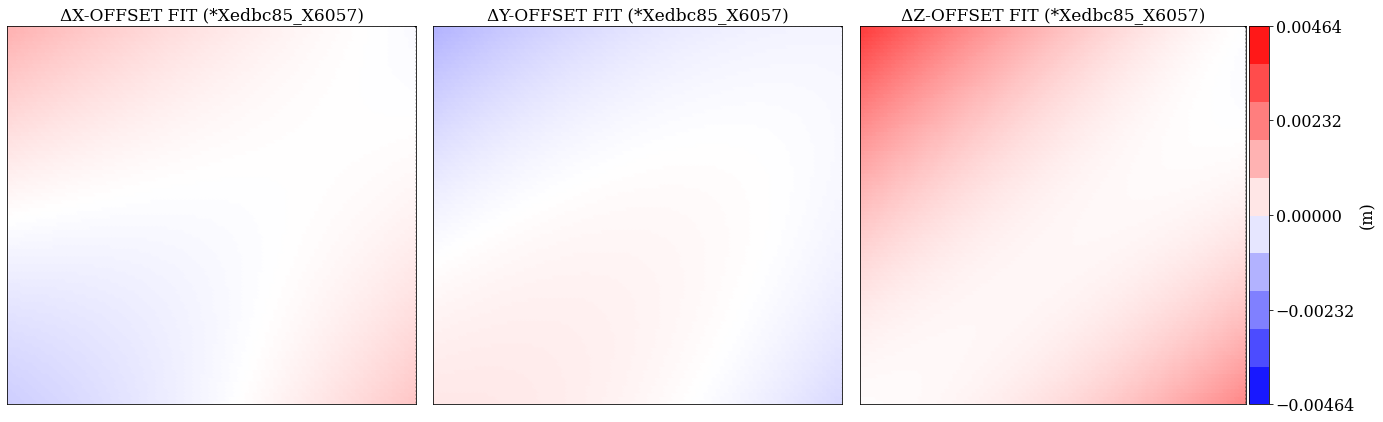

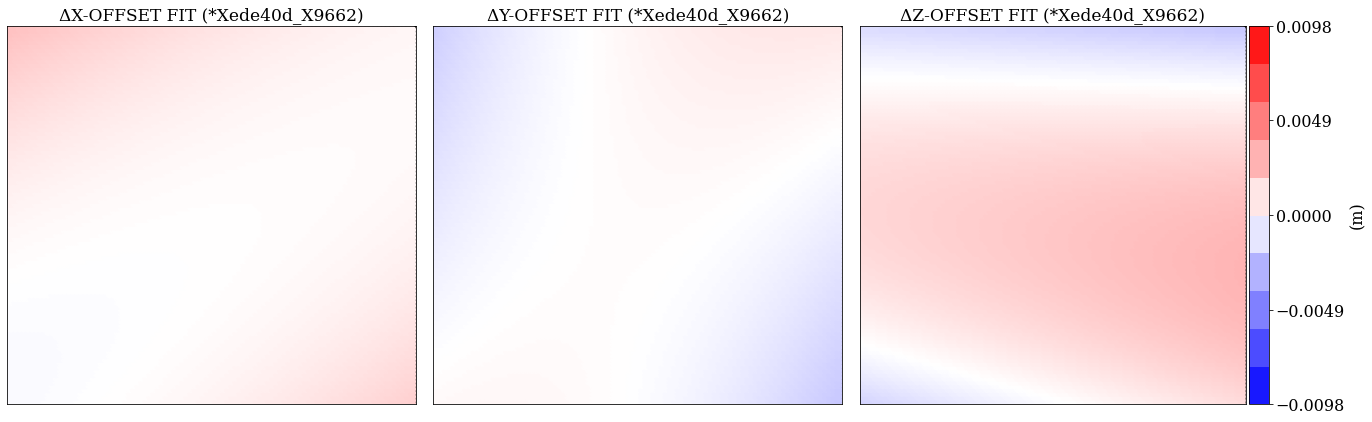

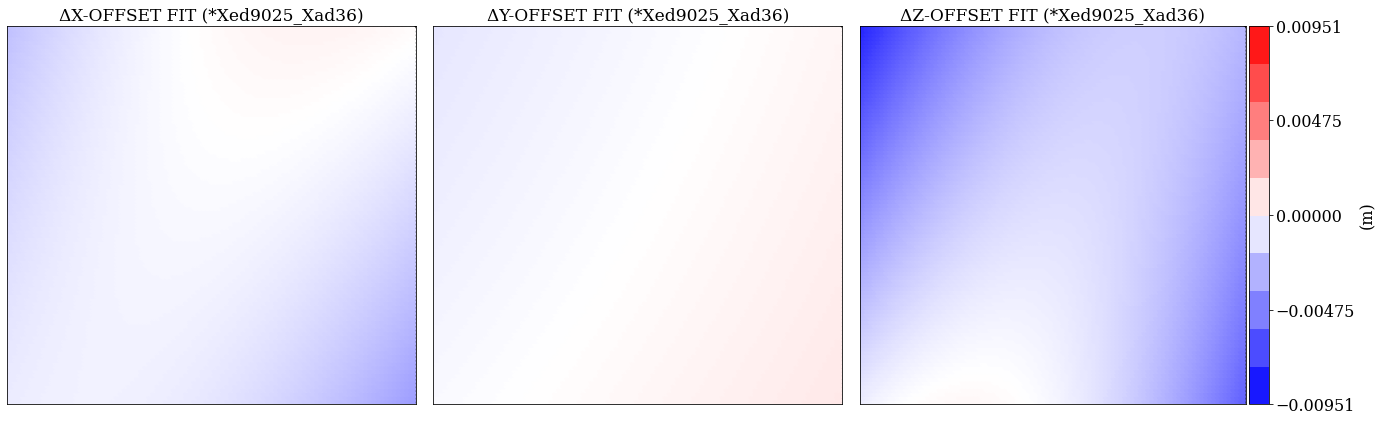

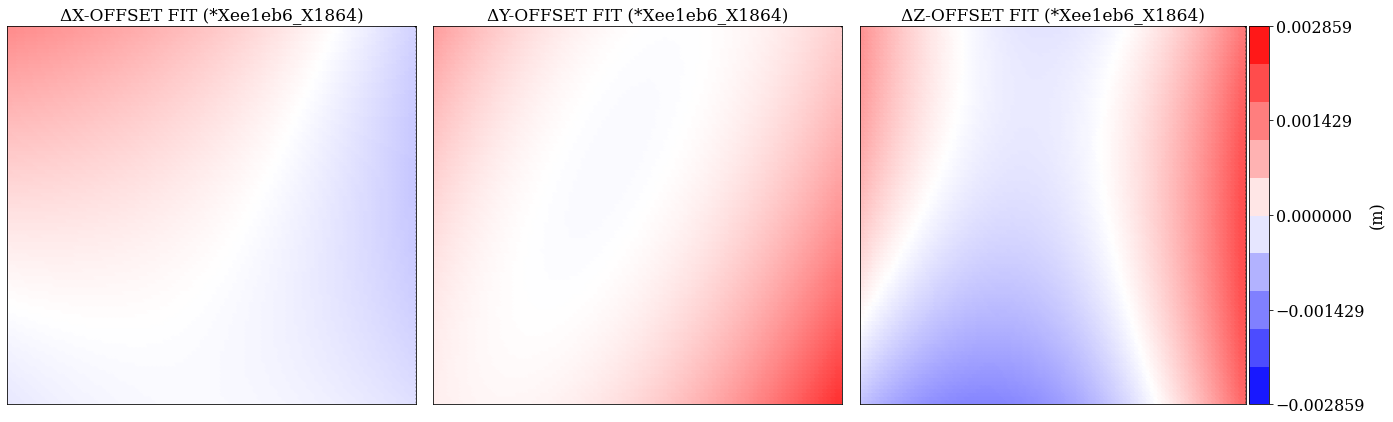

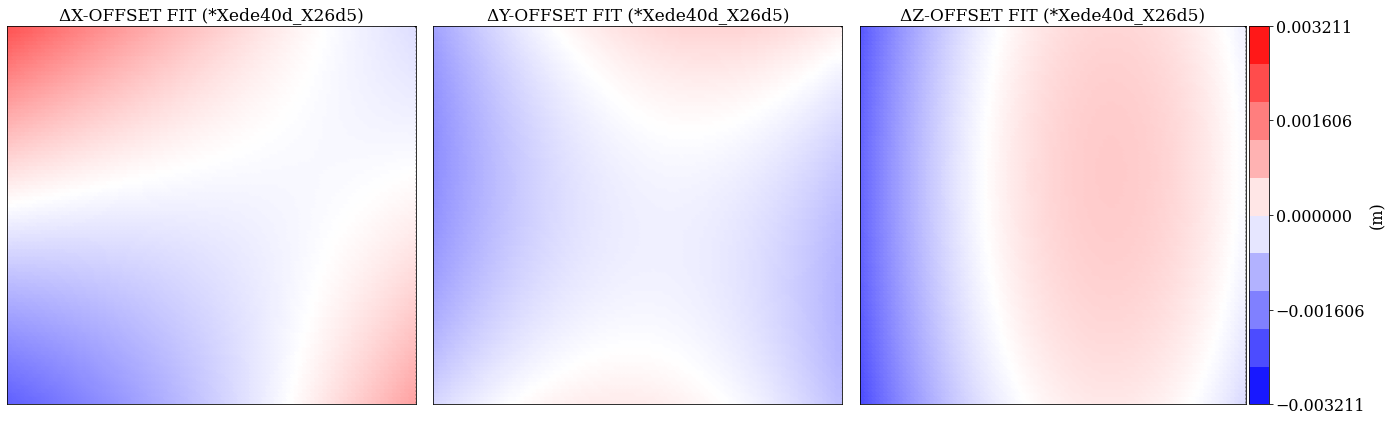

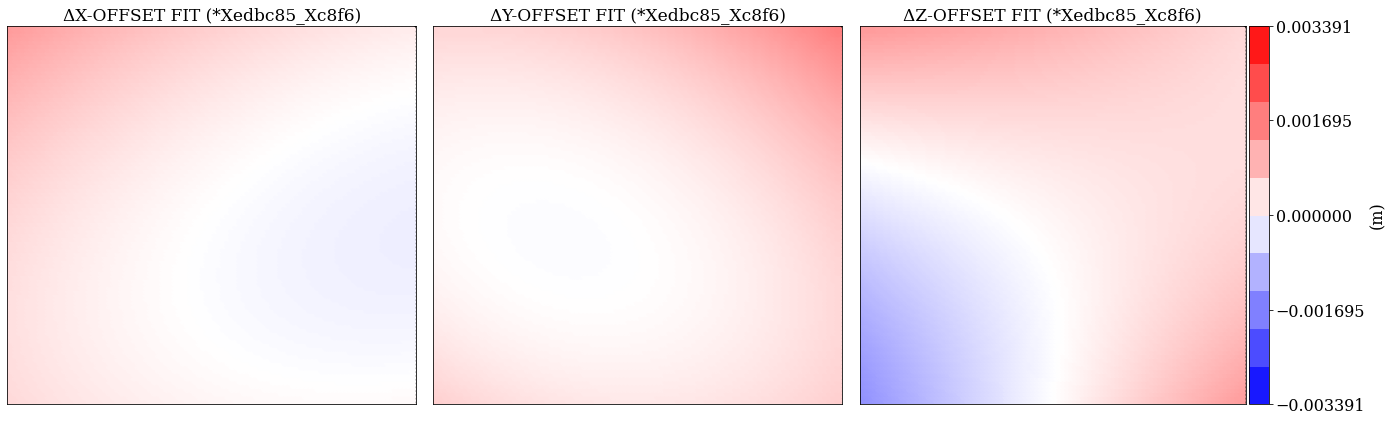

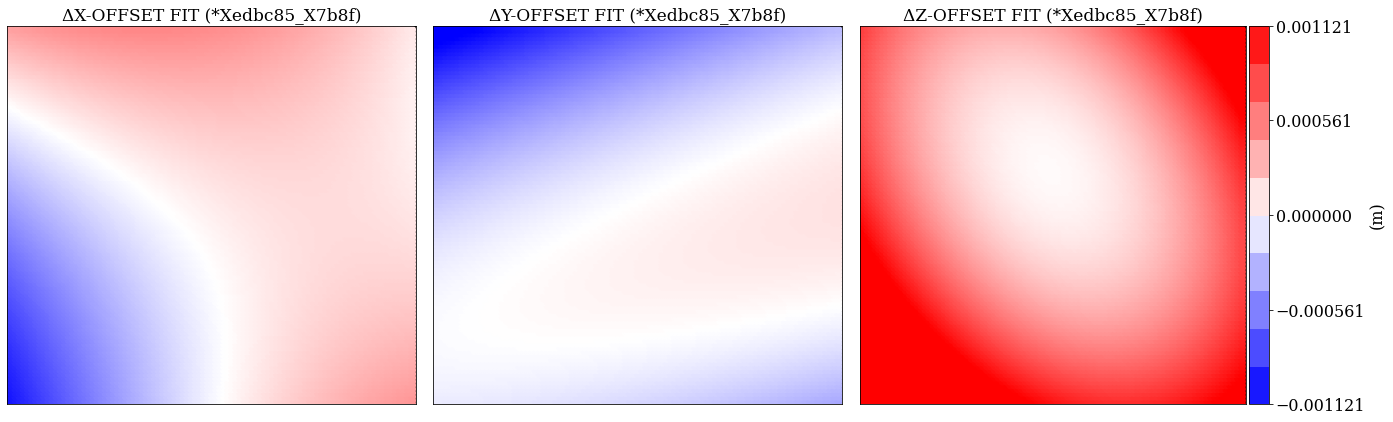

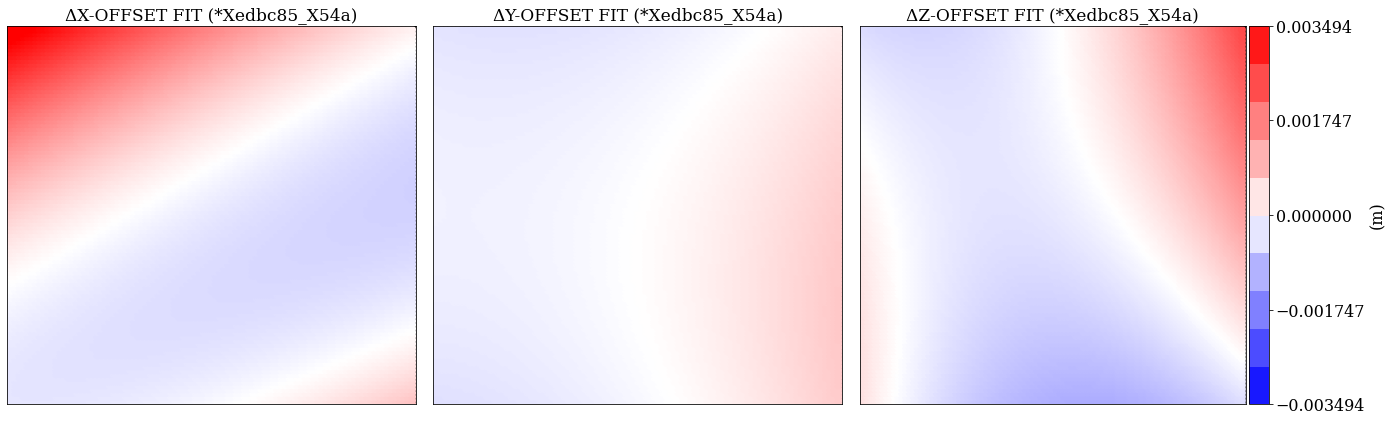

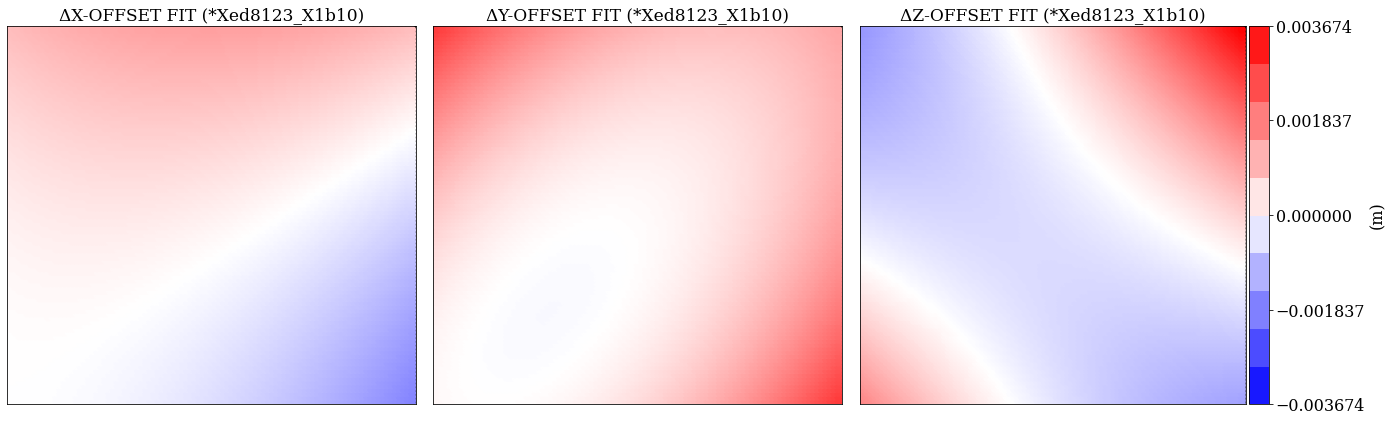

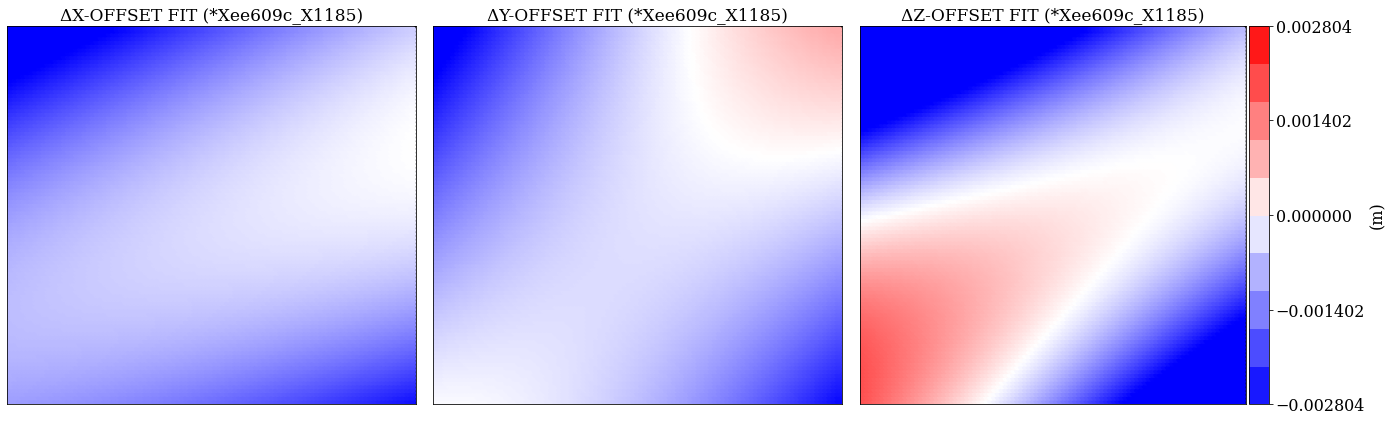

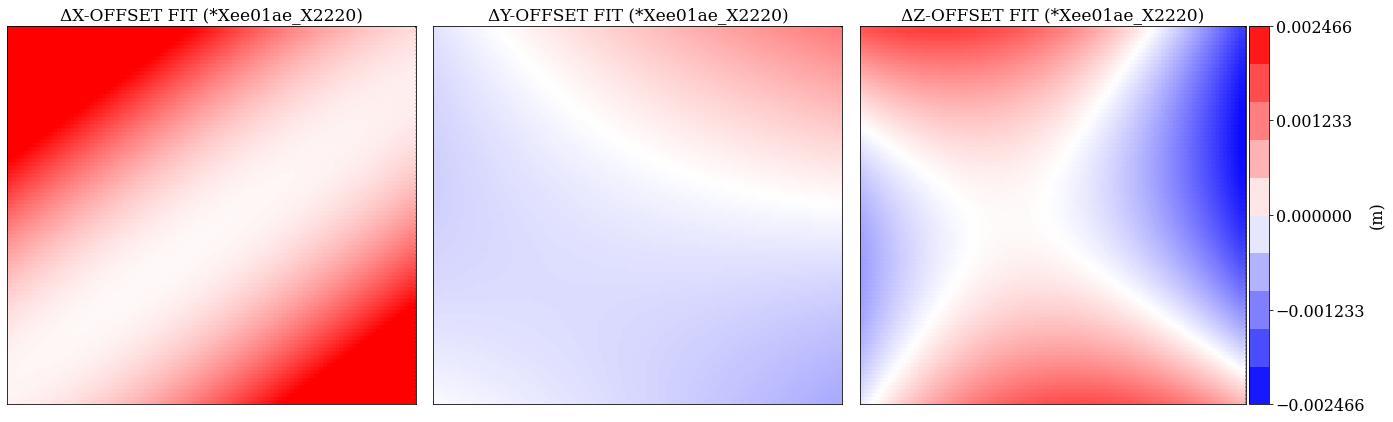

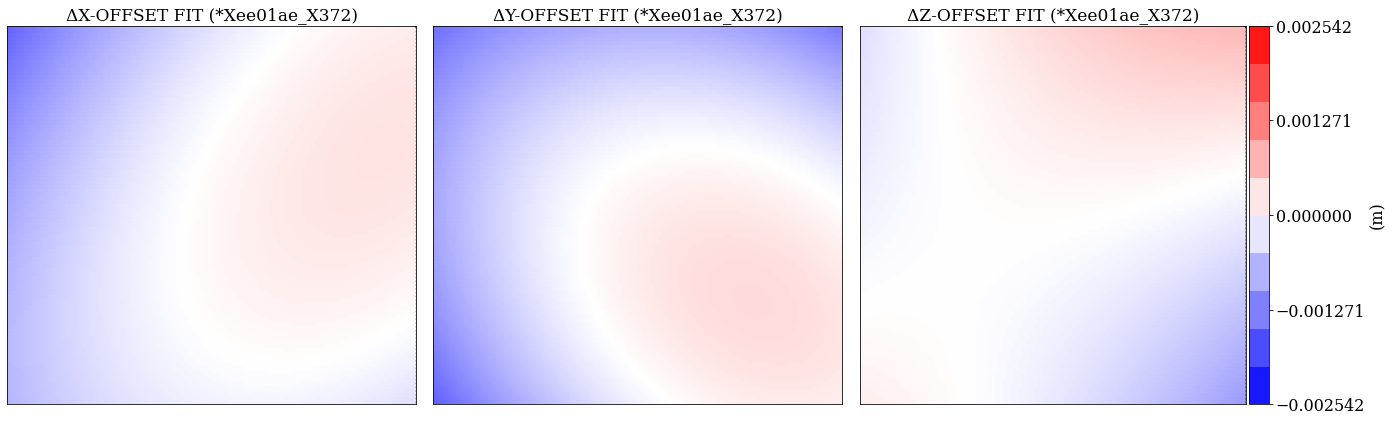

In [38]:
if not os.path.isdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/'):
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/magnitude/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/delta/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/magnitude/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/delta/')
directory = '/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/'

o = 0
first = True
for file in os.listdir(directory): ##for subdirectory in 7_12_2021
    if os.path.isdir(directory+file) and file[:3] == 'uid':
        if file in uids:
            if first:
                temp = np.genfromtxt(directory+file+'/AntPos.csv',delimiter=',',dtype='str',skip_header=2)
                oldpos = np.array((temp[:,3:9]),dtype='float')
                oldpos[:,3:5] = temp[:,15:17]
                oldpos[:,5] = temp[:,18]
                oldposnames = temp[:,0]
                first = False
            else:
                temp = np.genfromtxt(directory+file+'/AntPos.csv',delimiter=',',dtype='str',skip_header=2)
                pos = np.array((temp[:,3:9]),dtype='float')
                pos[:,3:5] = temp[:,15:17]
                pos[:,5] = temp[:,18]
                posnames = temp[:,0]

                if np.shape(pos)[0] > np.shape(oldpos)[0]:
                    pos = pos[:np.shape(oldpos)[0],:]
                else:
                    oldpos = oldpos[:np.shape(pos)[0],:]
                pos1 = pos

                ###################

                arr = np.empty((1,6),dtype='float')

                for i in range(np.shape(pos)[0]):
                    for j in range(np.shape(oldpos)[0]):
                        if posnames[i] == oldposnames[j] and pos[i,5] != 0 and oldpos[i,5] != 0:
                            temp = np.empty((1,6),dtype='float')
                            temp[0,:3] = pos[i,:3]-oldpos[j,:3]
                            temp[0,3:] = pos[i,3:]
                            arr = np.vstack((arr,temp))        
                pos = arr[1:,:]
                oldpos = pos1

                ############################################ Fits

                X = pos[:,3].astype('float')
                Y = pos[:,4].astype('float')

                ###############

                XOffset = pos[:,0].astype('float')
                YOffset = pos[:,1].astype('float')
                ZOffset = pos[:,2].astype('float')

                k = np.sort(XOffset)
                dev = (k[-4]-k[4])/2
                xmax = k[-4]+dev
                xmin = k[4]-dev

                k = np.sort(YOffset)
                dev = (k[-4]-k[4])/2
                ymax = k[-4]+dev
                ymin = k[4]-dev

                k = np.sort(ZOffset)
                dev = (k[-4]-k[4])/2
                zmax = k[-4]+dev
                zmin = k[4]-dev

                for j in range(np.shape(X)[0]):
                    if XOffset[j] > xmax:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if YOffset[j] > ymax:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if ZOffset[j] > zmax:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if XOffset[j] < xmin:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if YOffset[j] < ymin:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if ZOffset[j] < zmin:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0


                ###############

                xmax = np.max(X)+200
                ymax = np.max(Y)+200
                xmin = np.min(X)-200
                ymin = np.min(Y)-200

                poly = PolynomialFeatures(degree=2)
                X_t = poly.fit_transform(np.transpose(np.vstack((X,Y))))

                xFit = LinearRegression()
                xFit.fit(X_t, XOffset)
                xCoeff = xFit.coef_
                xInt = xFit.intercept_

                yFit = LinearRegression()
                yFit.fit(X_t, YOffset)
                yCoeff = yFit.coef_
                yInt = yFit.intercept_

                zFit = LinearRegression()
                zFit.fit(X_t, ZOffset)
                zCoeff = zFit.coef_
                zInt = zFit.intercept_

                ############################################

                x = np.arange(xmin, xmax, (xmax-xmin)/100)
                y = np.arange(ymin, ymax, (ymax-ymin)/100)
                if np.shape(x)[0] < np.shape(y)[0]: y = y[:np.shape(x)[0]]
                else: x = x[:np.shape(y)[0]]

                x, y = np.meshgrid(x,y)
                xOffset = xCoeff[1]*x+xCoeff[2]*y+xCoeff[3]*x**2+xCoeff[4]*x*y+xCoeff[5]*y**2+xInt
                yOffset = yCoeff[1]*x+yCoeff[2]*y+yCoeff[3]*x**2+yCoeff[4]*x*y+yCoeff[5]*y**2+yInt
                zOffset = zCoeff[1]*x+zCoeff[2]*y+zCoeff[3]*x**2+zCoeff[4]*x*y+zCoeff[5]*y**2+zInt

                temp = max(np.max(pos[:,:3]),-np.min(pos[:,:3]))
                vmin = -temp
                vmax = temp
                if vmax > 0.003:
                    circle = True
                else: circle = False
                norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
                
                #graph parameters
                width,height = 18,6
                xMajors,xMinors = 5,5
                yMajors,yMinors = 5,5

                #X PLOT

                fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(width,height))

                title='ΔX-OFFSET FIT (*'+file[11:]+')'

                ax1.scatter(x,y,norm=norm,c=xOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)

                plt.rc("font", size=16,family='serif')
                ax1.set_xlim(xmin,xmax)
                ax1.set_ylim(ymin,ymax)
                x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
                y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
                ax1.set_xticks([xmin+200,xmax-200])
                ax1.set_yticks([ymin+200,ymax-200])
                ax1.xaxis.set_minor_locator(x_minor_ticks)
                ax1.yaxis.set_minor_locator(y_minor_ticks)
                ax1.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
                ax1.set_xticklabels(['West','East'])
                ax1.set_yticklabels(['South','North'])
                ax1.set_title(title,fontsize=17)
                ax1.set_facecolor('xkcd:black')
                plt.tight_layout()

                #Y PLOT

                title='ΔY-OFFSET FIT (*'+file[11:]+')'

                ax2.scatter(x,y,norm=norm,c=yOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)

                plt.rc("font", size=16,family='serif')
                ax2.set_xlim(xmin,xmax)
                ax2.set_ylim(ymin,ymax)
                x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
                y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
                ax2.set_xticks([xmin+200,xmax-200])
                ax2.set_yticks([ymin+200,ymax-200])
                ax2.xaxis.set_minor_locator(x_minor_ticks)
                ax2.yaxis.set_minor_locator(y_minor_ticks)
                ax2.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
                ax2.set_xticklabels(['West','East'])
                ax2.set_yticklabels(['South','North'])
                ax2.set_title(title,fontsize=17)
                ax2.set_facecolor('xkcd:black')
                plt.tight_layout()

                #Z PLOT

                title='ΔZ-OFFSET FIT (*'+file[11:]+')'

                temp = ax3.scatter(x,y,norm=norm,c=zOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)

                plt.rc("font", size=16,family='serif')
                ax3.set_xlim(xmin,xmax)
                ax3.set_ylim(ymin,ymax)
                x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
                y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
                ax3.set_xticks([xmin+200,xmax-200])
                ax3.set_yticks([ymin+200,ymax-200])
                ax3.xaxis.set_minor_locator(x_minor_ticks)
                ax3.yaxis.set_minor_locator(y_minor_ticks)
                ax3.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
                ax3.set_xticklabels(['West','East'])
                ax3.set_yticklabels(['South','North'])
                ax3.set_title(title,fontsize=17)
                ax3.set_facecolor('xkcd:black')
                plt.tight_layout()

                colorbar(temp,norm,vmin,vmax)
                plt.show()
                #plt.savefig(directory+'geographyfitplots/plot/delta/deltageofit'+str(o)+'.png', bbox_inches='tight')
                #plt.close()

                o += 1

# surface plot (delta) w/ antennas

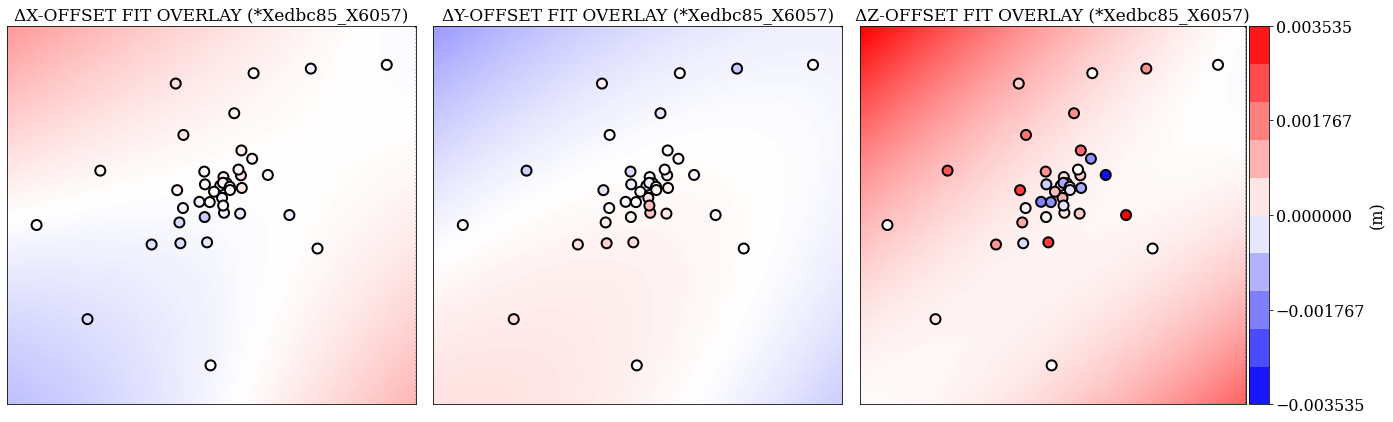

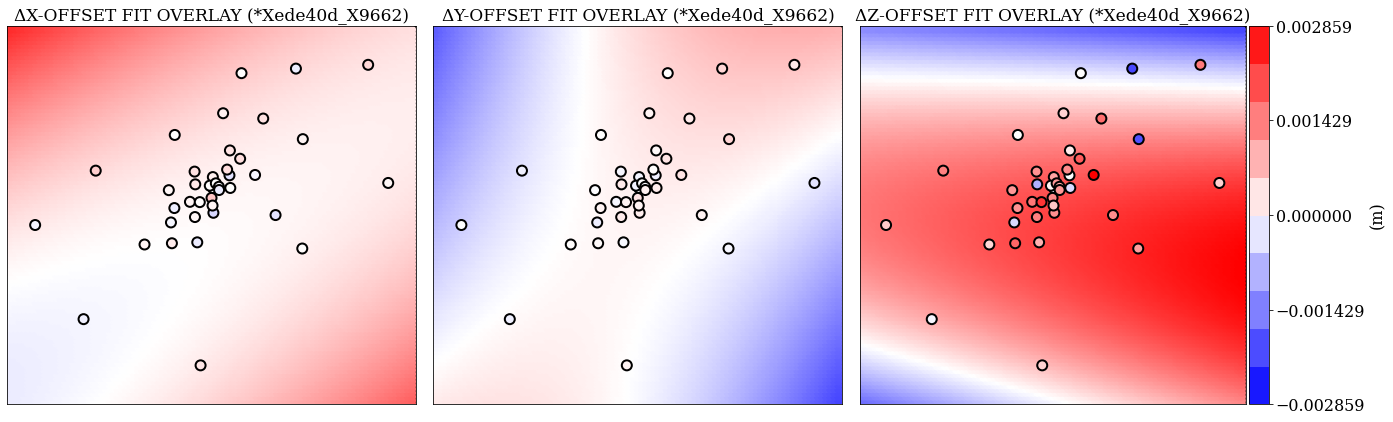

KeyboardInterrupt: 

In [32]:
if not os.path.isdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/'):
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/magnitude/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/plot/delta/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/magnitude/')
    os.mkdir('/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/geographyfitplots/antoverlay/delta/')
directory = '/Users/colemeyer/Documents/ALMA Internship/Observational Data/'+date+'/'

o = 0
first = True
for file in os.listdir(directory): ##for subdirectory in 7_12_2021
    if os.path.isdir(directory+file) and file[:3] == 'uid':
        if file in uids:
            if first:
                temp = np.genfromtxt(directory+file+'/AntPos.csv',delimiter=',',dtype='str',skip_header=2)
                oldpos = np.array((temp[:,3:9]),dtype='float')
                oldpos[:,3:5] = temp[:,15:17]
                oldpos[:,5] = temp[:,18]
                oldposnames = temp[:,0]
                first = False
            else:
                temp = np.genfromtxt(directory+file+'/AntPos.csv',delimiter=',',dtype='str',skip_header=2)
                pos = np.array((temp[:,3:9]),dtype='float')
                pos[:,3:5] = temp[:,15:17]
                pos[:,5] = temp[:,18]
                posnames = temp[:,0]

                if np.shape(pos)[0] > np.shape(oldpos)[0]:
                    pos = pos[:np.shape(oldpos)[0],:]
                else:
                    oldpos = oldpos[:np.shape(pos)[0],:]
                pos1 = pos

                ###################

                arr = np.empty((1,6),dtype='float')

                for i in range(np.shape(pos)[0]):
                    for j in range(np.shape(oldpos)[0]):
                        if posnames[i] == oldposnames[j] and pos[i,5] != 0 and oldpos[i,5] != 0:
                            temp = np.empty((1,6),dtype='float')
                            temp[0,:3] = pos[i,:3]-oldpos[j,:3]
                            temp[0,3:] = pos[i,3:]
                            arr = np.vstack((arr,temp))        
                pos = arr[1:,:]
                oldpos = pos1

                ############################################ Fits

                X = pos[:,3].astype('float')
                Y = pos[:,4].astype('float')

                ###############

                XOffset = pos[:,0].astype('float')
                YOffset = pos[:,1].astype('float')
                ZOffset = pos[:,2].astype('float')

                k = np.sort(XOffset)
                dev = (k[-4]-k[4])/2
                xmax = k[-4]+dev
                xmin = k[4]-dev

                k = np.sort(YOffset)
                dev = (k[-4]-k[4])/2
                ymax = k[-4]+dev
                ymin = k[4]-dev

                k = np.sort(ZOffset)
                dev = (k[-4]-k[4])/2
                zmax = k[-4]+dev
                zmin = k[4]-dev

                for j in range(np.shape(X)[0]):
                    if XOffset[j] > xmax:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if YOffset[j] > ymax:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if ZOffset[j] > zmax:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if XOffset[j] < xmin:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if YOffset[j] < ymin:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0
                    if ZOffset[j] < zmin:
                        XOffset[j] = 0
                        YOffset[j] = 0
                        ZOffset[j] = 0

                temp = max(np.max(XOffset),np.max(YOffset),np.max(ZOffset),-np.min(XOffset),-np.min(YOffset),-np.min(ZOffset))
                vmin = -temp
                vmax = temp
                if vmax > 0.003:
                    circle = True
                else: circle = False
                norm1 = mpl.colors.Normalize(vmin=vmin,vmax=vmax)

                ###############

                xmax = np.max(X)+200
                ymax = np.max(Y)+200
                xmin = np.min(X)-200
                ymin = np.min(Y)-200

                poly = PolynomialFeatures(degree=2)
                X_t = poly.fit_transform(np.transpose(np.vstack((X,Y))))

                xFit = LinearRegression()
                xFit.fit(X_t, XOffset)
                xCoeff = xFit.coef_
                xInt = xFit.intercept_

                yFit = LinearRegression()
                yFit.fit(X_t, YOffset)
                yCoeff = yFit.coef_
                yInt = yFit.intercept_

                zFit = LinearRegression()
                zFit.fit(X_t, ZOffset)
                zCoeff = zFit.coef_
                zInt = zFit.intercept_

                ############################################

                x = np.arange(xmin, xmax, (xmax-xmin)/100)
                y = np.arange(ymin, ymax, (ymax-ymin)/100)
                if np.shape(x)[0] < np.shape(y)[0]: y = y[:np.shape(x)[0]]
                else: x = x[:np.shape(y)[0]]

                x, y = np.meshgrid(x,y)
                xOffset = xCoeff[1]*x+xCoeff[2]*y+xCoeff[3]*x**2+xCoeff[4]*x*y+xCoeff[5]*y**2+xInt
                yOffset = yCoeff[1]*x+yCoeff[2]*y+yCoeff[3]*x**2+yCoeff[4]*x*y+yCoeff[5]*y**2+yInt
                zOffset = zCoeff[1]*x+zCoeff[2]*y+zCoeff[3]*x**2+zCoeff[4]*x*y+zCoeff[5]*y**2+zInt

                temp = max(np.max(xOffset),np.max(yOffset),np.max(zOffset),-np.min(xOffset),-np.min(yOffset),-np.min(zOffset))
                vmin = -temp
                vmax = temp
                if vmax > 0.002:
                    circle = True
                else: circle = False
                norm2 = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
                
                #graph parameters
                width,height = 18,6
                xMajors,xMinors = 5,5
                yMajors,yMinors = 5,5

                #X PLOT

                fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(width,height))

                title='ΔX-OFFSET FIT OVERLAY (*'+file[11:]+')'

                ax1.scatter(x,y,norm=norm2,c=xOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)
                ax1.scatter(X,Y,norm=norm1,s=100,c=XOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2,edgecolors='k')

                plt.rc("font", size=16,family='serif')
                ax1.set_xlim(xmin,xmax)
                ax1.set_ylim(ymin,ymax)
                x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
                y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
                ax1.set_xticks([xmin+200,xmax-200])
                ax1.set_yticks([ymin+200,ymax-200])
                ax1.xaxis.set_minor_locator(x_minor_ticks)
                ax1.yaxis.set_minor_locator(y_minor_ticks)
                ax1.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
                ax1.set_xticklabels(['West','East'])
                ax1.set_yticklabels(['South','North'])
                ax1.set_title(title,fontsize=17)
                ax1.set_facecolor('xkcd:black')
                plt.tight_layout()

                #Y PLOT

                title='ΔY-OFFSET FIT OVERLAY (*'+file[11:]+')'

                ax2.scatter(x,y,norm=norm2,c=yOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)
                ax2.scatter(X,Y,norm=norm1,s=100,c=YOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2,edgecolors='k')

                plt.rc("font", size=16,family='serif')
                ax2.set_xlim(xmin,xmax)
                ax2.set_ylim(ymin,ymax)
                x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
                y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
                ax2.set_xticks([xmin+200,xmax-200])
                ax2.set_yticks([ymin+200,ymax-200])
                ax2.xaxis.set_minor_locator(x_minor_ticks)
                ax2.yaxis.set_minor_locator(y_minor_ticks)
                ax2.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
                ax2.set_xticklabels(['West','East'])
                ax2.set_yticklabels(['South','North'])
                ax2.set_title(title,fontsize=17)
                ax2.set_facecolor('xkcd:black')
                plt.tight_layout()

                #Z PLOT

                title='ΔZ-OFFSET FIT OVERLAY (*'+file[11:]+')'

                temp = ax3.scatter(x,y,norm=norm2,c=zOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2)
                ax3.scatter(X,Y,norm=norm1,s=100,c=ZOffset,cmap=plt.cm.bwr,linestyle='-',linewidth=2,edgecolors='k')

                plt.rc("font", size=16,family='serif')
                ax3.set_xlim(xmin,xmax)
                ax3.set_ylim(ymin,ymax)
                x_minor_ticks = MultipleLocator(((xmax - xmin) / xMajors) / xMinors)
                y_minor_ticks = MultipleLocator(((ymax - ymin) / yMajors) / yMinors)
                ax3.set_xticks([xmin+200,xmax-200])
                ax3.set_yticks([ymin+200,ymax-200])
                ax3.xaxis.set_minor_locator(x_minor_ticks)
                ax3.yaxis.set_minor_locator(y_minor_ticks)
                ax3.tick_params(axis='both',which='both',bottom=False,top=False,right=False,left=False,labelleft=False,labelbottom=False)
                ax3.set_xticklabels(['West','East'])
                ax3.set_yticklabels(['South','North'])
                ax3.set_title(title,fontsize=17)
                ax3.set_facecolor('xkcd:black')
                plt.tight_layout()

                colorbar(temp,norm2,vmin,vmax)
                plt.show()
                #plt.savefig(directory+'geographyfitplots/antoverlay/delta/deltageofitants'+str(o)+'.png', bbox_inches='tight')
                #plt.close()

                o += 1